<h1>Table of Contents &lt;br&gt;&lt;/br&gt;<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-and-Data-loading" data-toc-modified-id="Imports-and-Data-loading-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports and Data loading</a></span></li><li><span><a href="#Result-loader" data-toc-modified-id="Result-loader-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Result loader</a></span></li><li><span><a href="#Seaborn-Style" data-toc-modified-id="Seaborn-Style-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Seaborn Style</a></span></li><li><span><a href="#Plotting-Function" data-toc-modified-id="Plotting-Function-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Plotting Function</a></span></li></ul></li><li><span><a href="#Profit-comparison" data-toc-modified-id="Profit-comparison-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Profit comparison</a></span></li><li><span><a href="#Learning-Comparison" data-toc-modified-id="Learning-Comparison-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Learning Comparison</a></span></li></ul></div>

## Imports and Data loading

In [1]:
# Display plots inline
%matplotlib inline

# Autoreload all package before excecuting a call
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from evsim.data import load

## Result loader

In [3]:
pd.set_option('display.float_format', '{:.4f}'.format)

start = "2016-06-01"
end = "2018-01-01"

def read_results(path):
    df = pd.read_csv(path)
    
    df["profit_eur"] = df["profit_eur"] - df["lost_rentals_eur"]
    df["charged_vpp_kwh"] = df["charged_vpp_kwh"] / 1000
    
    df["timestamp"] = df["timestamp"].apply(lambda x : datetime.fromtimestamp(x))
    df = df.set_index("timestamp") 
    df = df[start:end]
    return df

## Seaborn Style

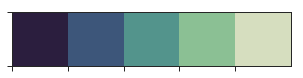

In [4]:
sns.set(rc={'figure.figsize':(10,6)})

sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 1.5, "lines.markersize": 7})

sns.set_style("white")
sns.set_style("ticks")


palette = sns.cubehelix_palette(5, start=.5, rot=-.75, reverse=True)
sns.set_palette(palette)

sns.palplot(palette)

## Plotting Function

In [5]:
def result_comp(dfs, names, a, y_col="profit_eur", y_name="Gross profit increase [EUR]"):
    df_results = pd.DataFrame(columns=["timestamp", "Strategy", y_name])
    for df, name in zip(dfs, names):
        
        df = df.groupby(pd.Grouper(freq="M")).sum()
        df[y_name] = df[y_col].cumsum()
        df = df.reset_index()
        df["Strategy"] = name
        df = df[["timestamp", "Strategy", y_name]]

        df_results = df_results.append(df)

    
    ax = sns.lineplot(x="timestamp", y=y_name,
                      hue="Strategy", style="Strategy",
                      markers=True, dashes=True, ci="sd", data=df_results, ax=a)

    ax.set(xlabel="")

# Profit comparison

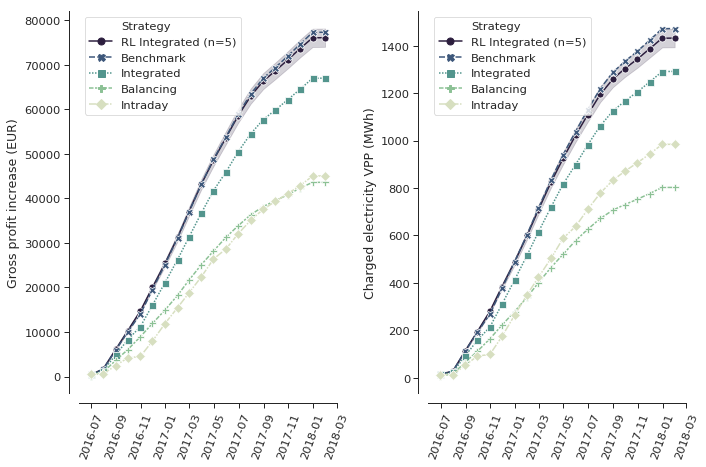

In [6]:
df_bench = read_results("../results/integrated-benchmark-acc-1.csv")
df_int = read_results("../results/integrated-risk-averse.csv")

df_rl1 = read_results("../results/integrated-rl-1.csv")
df_rl2 = df_rl1 * 0.99
df_rl3 = df_rl1 * 0.95

df_bal = df = read_results("../results/balancing-risk-averse.csv")
df_intr = df = read_results("../results/intraday-risk-averse.csv")

f, axs = plt.subplots(1, 2)
y_cols=["profit_eur", "charged_vpp_kwh"]
y_names=["Gross profit increase (EUR)", "Charged electricity VPP (MWh)"]

for ax, y_col, y_name in zip(axs, y_cols, y_names):
    result_comp(
        [
            df_rl1,
            df_rl2,
            df_rl3,
            df_bench,
            df_int,
            df_bal,
            df_intr,
        ],
        [
            "RL Integrated (n=5)",
            "RL Integrated (n=5)",
            "RL Integrated (n=5)",
            "Benchmark",
            "Integrated",
            "Balancing",
            "Intraday",
        ],
        ax, y_col, y_name
    )
    
f.tight_layout()
sns.despine(offset=10)
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=70)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=70)
plt.savefig("../results/fig/rl-results.png")

# Learning Comparison

           loss  mean_absolute_error    mean_q  mean_eps  episode_reward  \
count  288.0000             288.0000  288.0000  288.0000        288.0000   
mean   602.8725             570.4386  591.2672    0.5359        917.0922   
std    682.6570             336.6539  344.1409    0.2674        235.3348   
min     29.7728              18.4867   26.1764    0.1000        323.9380   
25%    187.8990             346.9983  362.9948    0.3018        753.2815   
50%    315.7055             465.9971  482.4300    0.5332        914.6400   
75%    645.1008             684.0146  705.8006    0.7705       1058.1265   
max   3889.7605            1497.3402 1544.8763    0.9724       1617.1040   

       nb_episode_steps   nb_steps  episode  duration  mean_reward  
count          288.0000   288.0000 288.0000  288.0000     288.0000  
mean           441.1257 26181.1590  59.5000   11.6568       2.3516  
std            110.8471 15237.4796  34.6712    2.9823       0.3971  
min            144.6000  1310.6000   2.

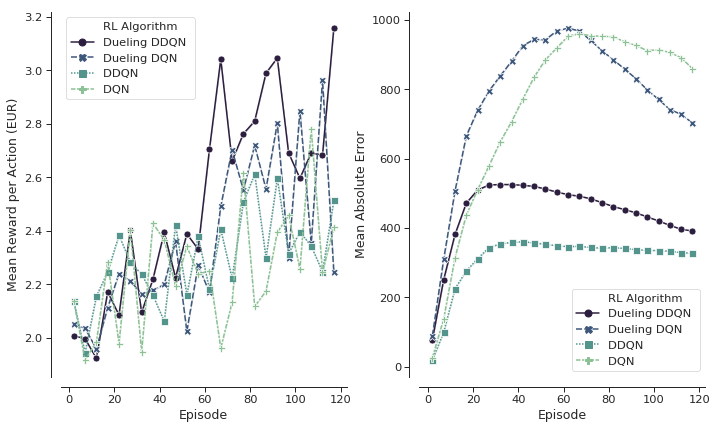

In [13]:
from pathlib import Path

def labels(key):
    label = key.strip("nb_").replace("_", " ").title()
    label = label + " per Action" if "Mean Reward" in label else label
    label = label + " (EUR)" if "Reward" in label else label
    return label

def algo_names(file):
    name = Path(file)
    name = name.stem
    name = ''.join([i for i in name if not i.isdigit()])
    name = name.replace("_", " ").upper()
    name = name.replace("DUEL", "Dueling")
    return name

def visualize_log(files, keys, grouper=10):
    df_learning = pd.DataFrame()
    
    
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
        if 'episode' not in data:
            raise ValueError('Log file "{}" does not contain the "episode" key.'.format(file))
        
        
        df = pd.DataFrame(data)
        df["mean_reward"] = df["episode_reward"] / df["nb_episode_steps"]
        df = df.groupby(df.index // grouper).mean()
        
        df["RL Algorithm"] = algo_names(file)
        df_learning = df_learning.append(df)
        
    
    df_learning = df_learning[df_learning["episode"] < 120]
    print(df_learning.describe())

    f, axs = plt.subplots(1, len(keys))
    for idx, key in enumerate(keys):
        g = sns.lineplot(x="episode", y=key, 
                     style="RL Algorithm", hue="RL Algorithm",
                     dashes=True, markers=True, ci=0,
                     data=df_learning, ax=axs[idx])
        
        ylabel=labels(key)
        g.set(xlabel='Episode', ylabel=ylabel)    
        
        #plt.xticks(np.arange(0, df_learning["episode"].max() + 1, 30));  
        
    plt.tight_layout()
    plt.tight_layout()
    sns.despine(offset=10)


logs = [
        "../results/rl/duel_ddqn_1.json", 
        "../results/rl/duel_ddqn_2.json", 
        "../results/rl/duel_ddqn_3.json", 
        "../results/rl/duel_dqn_1.json", 
        "../results/rl/duel_dqn_2.json", 
        "../results/rl/duel_dqn_3.json", 
        "../results/rl/ddqn_1.json", 
        "../results/rl/ddqn_2.json", 
        "../results/rl/ddqn_3.json", 
        "../results/rl/dqn_1.json",
        "../results/rl/dqn_2.json",
        "../results/rl/dqn_3.json",
       ]
cols = ["mean_reward", "mean_absolute_error"]
visualize_log(logs, cols, grouper=5)

In [8]:
file =  "../results/rl/ddqn_1.json"

with open(file, 'r') as f:
    data = json.load(f)
if 'episode' not in data:
    raise ValueError('Log file "{}" does not contain the "episode" key.'.format(file))


df = pd.DataFrame(data)
df["mean_reward"] = df["episode_reward"] / df["nb_episode_steps"]
print(df.head(10))
df = df.groupby(df.nb_steps // 1000).mean()
print(df.head(10))


      loss  mean_absolute_error   mean_q  mean_eps  episode_reward  \
0      nan                  nan      nan       nan       1259.7800   
1  28.5653               5.6034   9.8377    0.9787       1203.1500   
2  15.8261              11.6163  22.5056    0.9752         58.1000   
3  46.0995              22.9629  31.3526    0.9707        853.4200   
4  33.9262              38.9161  50.2878    0.9650        265.5700   
5  51.9020              52.4062  64.1446    0.9601        579.9000   
6  60.3310              77.2002  91.8989    0.9497       1416.4000   
7  99.3678             109.5266 127.1876    0.9383        987.5800   
8 109.2016             120.3974 140.4453    0.9333        126.3800   
9 133.2007             141.4804 160.9559    0.9266       1200.8000   

   nb_episode_steps  nb_steps  episode  duration  mean_reward  
0               696       696        0   17.8343       1.8100  
1               676      1372        1   19.3073       1.7798  
2                16      1388        